In [1]:
import numpy as np

import random
import h5py
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
from keras.initializers import *
from keras.models import load_model
import theano.tensor as T
import theano
from sklearn import metrics
from sklearn.preprocessing import *
from scipy.fftpack import dct, idct

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# external custom code I wrote
from load_data import *
from windowing import *
from utility import *
from pesq import *
from noise import *
from consts import *
from nn_blocks import *

In [3]:
# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# number of speech files for train, val, and test
TRAIN_SIZE = 1000
VAL_SIZE = 100
TEST_SIZE = 500

# during training, we evaluate PESQ and RMSE and such on full speech files every epoch, which
# is kind of expensive. so instead of selecting the full training and validation set, we
# randomly select this many waveforms
TRAIN_EVALUATE = 50
VAL_EVALUATE = 50

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101814, 512, 1)
6.41179e-06
0.103588
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
from keras.activations import softmax
from sklearn.cluster import KMeans, MiniBatchKMeans

# softmax hardness variable
tau = K.variable(500.0, name = "hardness")
anneal_rate = 1.01
max_tau = 500.0

NBINS = 256
VEC_SIZE = 8

# to get an initialization, we sample random vectors and perform
# K-means clustering
random_vecs = []
for i in xrange(0, 10000):
    w_idx = random.randint(0, train_processed.shape[0])
    r_idx = random.randint(0, WINDOW_SIZE - VEC_SIZE)
    
    random_vecs.append((train_processed[w_idx, r_idx:r_idx+VEC_SIZE]).flatten())
random_vecs = np.array(random_vecs)

km = MiniBatchKMeans(n_clusters = NBINS).fit(random_vecs)
BINS_INIT = km.cluster_centers_
QUANT_BINS = K.variable(BINS_INIT)

print BINS_INIT

def unquantize_batch(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [2, 0])
    out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
    return out

def unquantize_vec(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [1, 0])
    out = K.reshape(out, (WINDOW_SIZE,))
    return out

class SoftmaxQuantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxQuantization, self).__init__(**kwargs)
   
    def build(self, input_shape):
        self.trainable_weights = [QUANT_BINS]
        super(SoftmaxQuantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        # x is an array: [BATCH x WINDOW_SIZE]
        # x_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x NBINS x VEC_SIZE]
        x_r = K.reshape(x, (-1, x.shape[1] / VEC_SIZE, 1, VEC_SIZE))
        x_r = K.repeat_elements(x_r, QUANT_BINS.shape[0], -2)

        # quant_bins is an array: [NBINS x VEC_SIZE] 
        # q_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x NBINS x VEC_SIZE]
        q_r = K.reshape(QUANT_BINS, (1, 1, QUANT_BINS.shape[0], VEC_SIZE))
        q_r = K.repeat_elements(q_r, x_r.shape[0], 0)
        q_r = K.repeat_elements(q_r, x_r.shape[1], 1)

        # get L2 distance from each element to each of the bins
        dist = K.sqrt(K.sum(K.square(x_r - q_r), axis = -1) + K.epsilon())

        # turn into softmax probabilities, which we return
        probs = softmax(tau * -dist)
        return probs
        
        '''
        # hard probabilities if tau >= max, or if we're at test time
        hard = K.one_hot(K.argmax(probs), NBINS)
        
        train = probs
        test = hard
        return K.in_train_phase(train, test)
        '''
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] / VEC_SIZE, NBINS)


class SoftmaxDequantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxDequantization, self).__init__(**kwargs)
        self.supports_masking = False
    
    def build(self, input_shape):
        self.trainable_weights = []
        super(SoftmaxDequantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        out = T.tensordot(x, QUANT_BINS, axes = [2, 0])
        out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
        return out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * VEC_SIZE)

[[ -3.96761149e-02  -4.39271256e-02  -4.69635613e-02 ...,  -7.85425082e-02
   -6.27530366e-02  -2.65182182e-02]
 [  1.56846121e-02   1.76133960e-01   2.96947867e-01 ...,   5.76197565e-01
    5.66659629e-01   4.65663403e-01]
 [ -1.85014471e-01  -1.95722222e-01  -2.03725934e-01 ...,  -4.39216197e-02
    3.87752093e-02   1.17567971e-01]
 ..., 
 [ -1.13581645e-03  -8.60339846e-04  -1.05027761e-03 ...,  -1.69633160e-04
   -6.96051517e-04  -4.74089873e-04]
 [  1.18692615e-03   2.88486527e-03   2.90806009e-03 ...,   1.19223492e-03
    2.90767453e-03   3.28441383e-03]
 [ -2.42369293e-04  -1.88418734e-03   5.64398128e-04 ...,  -2.45462218e-03
   -7.66392273e-04   4.92912531e-03]]


In [8]:
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 9
    
    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)
    
    # increase number of channels via convolution
    enc = channel_increase_block(NCHAN, FILT_SIZE)(enc)
    
    enc = residual_block(NCHAN, FILT_SIZE, 8)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 4)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 2)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    
    # decrease back down to 1 channel
    enc = channel_decrease_block(NCHAN, FILT_SIZE)(enc)
    
    enc = Reshape((WINDOW_SIZE,))(enc)
    
    # softmax quantization
    enc = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (WINDOW_SIZE / VEC_SIZE, NBINS))
    #dec_input = Input(shape = (WINDOW_SIZE,))
    dec = dec_input
    
    dec = SoftmaxDequantization()(dec)
    
    # increase number of channels via convolution
    dec = Reshape((WINDOW_SIZE, 1))(dec)
    
    dec = channel_increase_block(NCHAN, FILT_SIZE)(dec)
    
    dec = residual_block(NCHAN, FILT_SIZE, 8)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 4)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 2)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    
    dec = channel_decrease_block(NCHAN, FILT_SIZE)(dec)
    
    #dec = Activation('tanh')(dec)
    dec = Lambda(lambda x : K.clip(x, -1.0, 1.0))(dec)
    
    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec

In [9]:
# ---------------------------------------------------------------------------
# perceptual model: takes a clean window and "dirty" window, and computes
# a perceptual score between them
#     (0.0 to 1.0, where 0 is completely garbage and 1 is perfect)
# perceptual score is based off PESQ in this case
# ---------------------------------------------------------------------------
def perceptual_model_structure(dim):
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -
    NCHAN = 32
    FILT_SIZE = 9
    DENSE_SIZE = 32

    # - - - - - - - - - - - - - - - - - - - - -
    # shared Siamese structure applied to both inputs
    # - - - - - - - - - - - - - - - - - - - - -
    def siamese_half():
        inp = Input(shape = (WINDOW_SIZE, 1))
        ret = inp
        
        ret = channel_increase_block(NCHAN, FILT_SIZE)(ret)
        
        ret = downsample_block(NCHAN, FILT_SIZE)(ret)
        ret = downsample_block(NCHAN, FILT_SIZE)(ret)
        ret = residual_block(NCHAN, FILT_SIZE)(ret)
        ret = residual_block(NCHAN, FILT_SIZE)(ret)
        
        ret = channel_decrease_block(NCHAN, FILT_SIZE)(ret)
        
        ret = Flatten()(ret)
        ret = Dense(DENSE_SIZE, activation = 'linear', kernel_initializer = W_INIT)(ret)

        return Model(inputs = inp, outputs = ret)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # combined model
    # - - - - - - - - - - - - - - - - - - - - -
    input_orig = Input(shape = dim)
    input_dirty = Input(shape = dim)

    base_network = siamese_half()
    processed_a = base_network(input_orig)
    processed_b = base_network(input_dirty)

    out = EuclideanDistance()([processed_a, processed_b])
    #out = Lambda(lambda x : x[0] - x[1],
    #             output_shape = lambda x : x[0])([processed_a, processed_b])
    
    out = Dense(1, activation = 'sigmoid', kernel_initializer = W_INIT)(out)
    
    model = Model(inputs = [input_orig, input_dirty], outputs = out)
    return model

In [10]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (code.shape[0] * code.shape[1], NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    return entropy

def code_sparsity(placeholder, code):
    return -K.mean(K.sum(code * K.log(code + K.epsilon()), axis = -1), axis = -1)

In [11]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'EuclideanDistance': EuclideanDistance,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'NBINS' : NBINS,
                  'QUANT_BINS' : QUANT_BINS, 
                  'VEC_SIZE' : VEC_SIZE}

In [12]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 512, 1)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [13]:
# construct perceptual model (or load one if one is saved)
if (os.path.isfile('./percept_model.h5')):
    print "Loading ./percept_model.h5"
    perceptual_model = load_model('./percept_model.h5', KERAS_LOAD_MAP)
else:
    print "Creating new perceptual model"
    perceptual_model = perceptual_model_structure(input_dim)
perceptual_model.name = 'perceptual'

Creating new perceptual model


In [14]:
# compile perceptual model
make_trainable(autoencoder, False)
perceptual_model.compile(loss = rmse, optimizer = Adam(lr = 0.001))

In [15]:
# model parameters
loss_weights = [300.0, 2.0, 5.0]
loss_functions = [rmse, rmse, code_sparsity]
n_recons = 1
n_percept = 1
n_code = 1
assert(n_recons + n_percept + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [16]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = autoencoder.layers[1](model_input)
model_reconstructed = autoencoder.layers[2](model_embedding)
model_percept_score = perceptual_model([model_input, model_reconstructed])

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_percept_score] * n_percept + \
                                            [model_embedding] * n_code)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [17]:
make_trainable(autoencoder, True)
make_trainable(perceptual_model, False)

model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam(lr = 0.001, clipnorm = 1.0))
make_trainable(perceptual_model, True)

autoencoder.summary()
perceptual_model.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 64, 256)           44931     
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            42883     
Total params: 87,814.0
Trainable params: 87,814.0
Non-trainable params: 0.0
_________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 512, 1)        0                                            
_____________________________________________________________________________________________

In [18]:
# test model on a set of speech windows (which should originally have been extracted in
# order from some speech waveform)
def test_model_on_windows(orig_windows, wparams, autoencoder, argmax = False):
    # first, get desired reconstruction
    desired = reconstruct_from_windows(orig_windows, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocess_waveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    
    # then, run NN on windows to get our model's reconstruction
    transformed = np.reshape(orig_windows, (orig_windows.shape[0], WINDOW_SIZE, 1))
    enc = autoencoder.layers[1]
    embed = enc.predict(transformed, batch_size = 128, verbose = 0)
    if (argmax):
        for wnd in xrange(0, embed.shape[0]):
            max_idxs = np.argmax(embed[wnd], axis = -1)
            embed[wnd] = np.eye(NBINS)[max_idxs]
    
    dec = autoencoder.layers[2]
    autoencOutput = dec.predict(embed, batch_size = 128, verbose = 0)
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    recons = reconstruct_from_windows(autoencOutput, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocess_waveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    # compute PESQ between desired and reconstructed waveforms
    pesq = run_pesq_waveforms(desired, recons)
    
    # return some metrics, as well as the two waveforms
    metrics = [
        mse(recons, desired),
        avgErr(recons, desired),
        pesq
    ]
    
    return metrics, desired, recons

In [19]:
# test model given the filename for a .wav file
def test_model_on_wav(wave_filename, prefix, autoencoder,
                      lead = "", save_recons = True, verbose = True,
                      argmax = False):
    [rate, data] = sciwav.read(wave_filename)
    data = data.astype(np.float32)
    processed_wave, wparams = preprocess_waveform(data)
    windows = extract_windows(processed_wave, STEP_SIZE, OVERLAP_SIZE)
    
    metrics, desired, recons = test_model_on_windows(windows, wparams, autoencoder, argmax)
    
    if (save_recons):
        outFilename = prefix + "_output.wav"
        sciwav.write(outFilename, SAMPLE_RATE, recons.astype(np.int16))
    
    if (verbose):
        print lead + "MSE:        ", metrics[0]
        print lead + "Avg err:    ", metrics[1]
        print lead + "PESQ:       ", metrics[2]
        
    return metrics

In [20]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_res_uninit_", autoencoder)

MSE:         28838.3
Avg err:     83.1678
PESQ:        1.341


[28838.252, 83.167831, 1.341]

In [21]:
def evaluate_training(autoencoder, lead = ""):
    train_eval_idxs = random.sample(range(0, len(train_windows) - 1), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows) - 1), VAL_EVALUATE)
    
    train_metrics = []
    for idx in train_eval_idxs:
        windows = train_windows[idx]
        wparams = train_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        train_metrics.append(metrics)
        
    val_metrics = []
    for idx in val_eval_idxs:
        windows = val_windows[idx]
        wparams = val_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        val_metrics.append(metrics)
    
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [22]:
def save_model():
    os.system('rm ./best_model.h5')
    os.system('rm ./best_auto.h5')
    os.system('rm ./best_percept.h5')
    os.system('rm ./best_quant_bins.npy')
    
    model.save('./best_model.h5')
    autoencoder.save('./best_auto.h5')
    perceptual_model.save('./best_percept.h5')
    np.save('./best_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('best_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [23]:
def update_train_structure(X, y, wnd, cor, prm, val = None):
    if (val is None):
        pesq = run_pesq_windows(wnd, cor, prm, prm)
        scaled = (pesq - 1.0) / 3.5
        scaled = np.clip(scaled, 0.0, 1.0)
    else:
        scaled = val
    
    for i in xrange(0, wnd.shape[0]):
        X[0].append(wnd[i])
        X[1].append(cor[i])
        y.append(scaled)
        
    return X, y

def generate_pesq_traindata():
    X = [[], []]
    y = []
    
    # get random waveform from training set
    idx = random.randint(0, TRAIN_SIZE - 1)
    
    wnd = train_windows[idx]
    prm = train_wparams[idx]
    
    # autoencoder prediction
    wnd = np.reshape(wnd, (-1, WINDOW_SIZE, 1))
    cor = autoencoder.predict(wnd, verbose = 0)
    X, y = update_train_structure(X, y, wnd, cor, prm)
    
    # linear mix of prediction and original
    amt = random.uniform(0.25, 0.75)
    cor = cor * amt + wnd * (1.0 - amt)
    X, y = update_train_structure(X, y, wnd, cor, prm)
    
    # random type of noise, at random amount
    noise = random.choice(noise_types)
    noise_func = noise[0]
    noise_prm = random.choice(noise[1])
    
    wnd = np.reshape(wnd, (-1, WINDOW_SIZE))
    cor = noise_func(wnd, noise_prm)
    wnd = np.reshape(wnd, (-1, WINDOW_SIZE, 1))
    cor = np.reshape(cor, (-1, WINDOW_SIZE, 1))
    
    X, y = update_train_structure(X, y, wnd, cor, prm)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

#pesq_train_X, pesq_train_y = generate_pesq_traindata()
#print pesq_train_X.shape
#print pesq_train_y.shape

In [24]:
def avg_weight_change(before, after):
    avg = 0.0
    
    for i in xrange(0, len(before)):
        diff = np.mean(np.abs(before[i] * 1000.0 - after[i] * 1000.0))
        avg += diff
        
    avg /= float(len(before))
    return avg

In [25]:
def create_discrim_pairs(autoencoder, batch):
    num = batch.shape[0]
    pairs = []
    labels = []
    
    generated = autoencoder.predict(batch)
    
    #off = random.choice([0, 1])
    for i in xrange(0, num):
        batch_sample = batch[i, :, :]
        gen_sample = generated[i, :, :]
        
        #lbl = i % 2
        lbl = random.choice([0, 1])
        if (lbl == 0):
            # "real" sample comes first
            pairs += [[batch_sample, gen_sample]]
        else:
            # "fake" sample comes first
            pairs += [[gen_sample, batch_sample]]
        
        labels += [lbl]
        
    pairs = np.array(pairs)
    labels = np.array(labels)
    pairs = [pairs[:, 0, :, :], pairs[:, 1, :, :]]
    
    return pairs, labels

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 200

PESQ_TIMES_TRAIN = 1

lead = "    "
a_losses = []
d_acc = 0.0

best_val_pesq = 0.0
decreased_lr = False

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["no auto"]
        p_loss = "no pesq"
        
        # target for autoencoder
        a_y = [batch] * n_recons + \
              [np.ones(nbatch)] * n_percept + \
              [np.zeros((nbatch, WINDOW_SIZE, NBINS))] * n_code
            
        #a_weights_before = autoencoder.get_weights()
        #p_weights_before = perceptual_model.get_weights()
        
        # train perceptual model
        if (n_percept > 0):
            dsc_batch_X, dsc_batch_y = create_discrim_pairs(autoencoder, batch)
            p_loss = perceptual_model.train_on_batch(dsc_batch_X, dsc_batch_y)
            
            '''
            # get 128 random sample-label pairs for this batch
            nsamples = pesq_train_y.shape[0]
            p = np.random.permutation(nsamples)
            if (nsamples > BATCH_SIZE):
                p = p[:BATCH_SIZE]
            pesq_batch_X = [pesq_train_X[0, p], pesq_train_X[1, p]]
            pesq_batch_y = pesq_train_y[p]
                
            for k in xrange(0, PESQ_TIMES_TRAIN):
                p_loss = perceptual_model.train_on_batch(pesq_batch_X, pesq_batch_y)
            '''
            #a_weights_after = autoencoder.get_weights()
            #p_weights_after = perceptual_model.get_weights()
            
            #print avg_weight_change(a_weights_before, a_weights_after), \
            #      avg_weight_change(p_weights_before, p_weights_after)
            #a_weights_before = a_weights_after
            #p_weights_before = p_weights_after
                
        # train autoencoder
        a_losses = model.train_on_batch(batch, a_y)
        
        #a_weights_after = autoencoder.get_weights()
        #p_weights_after = perceptual_model.get_weights()

        #print avg_weight_change(a_weights_before, a_weights_after), \
        #      avg_weight_change(p_weights_before, p_weights_after)
        
        # update tau
        K.set_value(tau, np.min([K.get_value(tau) * anneal_rate, max_tau]))
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + \
                                             str(p_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau),
                
            if (n_percept > 0):
                pesq_train_X, pesq_train_y = generate_pesq_traindata()
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"   
    
    
    # ---------------------------------------------------------
    # estimate code entropy from random samples
    # ---------------------------------------------------------
    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    code = encoder.predict(X_train[rows, :], verbose = 0)
    probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
    hist = np.sum(probs, axis = 0)
    hist /= np.sum(hist)

    entropy = 0
    for i in hist:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    
    print lead + "----------------"
    print lead + "Code entropy:", entropy
    
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_res_reg_train_epoch" + str(epoch+1),
                              autoencoder, lead = lead, verbose = False, argmax = True)
    print lead + "SA1:        ", metrics
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_res_reg_train_epoch" + str(epoch+1),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
    print lead + "SX383:      ", metrics_tst
    
    if (K.get_value(tau) >= max_tau):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq
            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
        
        if (best_val_pesq > 3.00 and not decreased_lr):
            decreased_lr = True
            curr_lr = model.optimizer.lr.get_value()
            K.set_value(model.optimizer.lr, curr_lr / 5.0)
            print lead + "Decreased learning rate from", curr_lr, "to", curr_lr / 5.0
    else:
        print lead + "    (Not saving model yet)"
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"

Epoch 1:
    3840: 0.496930241585  [5.804619 0.014008 0.517279 0.113547] [5.804619 4.202328 1.034558 0.567733] 500.0

In [27]:
'''
model = load_model('best_model.h5', KERAS_LOAD_MAP)
autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
perceptual_model = load_model('best_percept.h5', KERAS_LOAD_MAP)
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]
QUANT_BINS = K.variable(np.load('best_quant_bins.npy'))
'''

"\nmodel = load_model('best_model.h5', KERAS_LOAD_MAP)\nautoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)\nperceptual_model = load_model('best_percept.h5', KERAS_LOAD_MAP)\nencoder = autoencoder.layers[1]\ndecoder = autoencoder.layers[2]\nQUANT_BINS = K.variable(np.load('best_quant_bins.npy'))\n"

In [28]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [29]:
test_model_on_wav("./SA1.wav", "SA1_final_", autoencoder)
test_model_on_wav("./SA1.wav", "SA1_final_", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final_", autoencoder)
test_model_on_wav("./SX383.wav", "SX383_final_", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final_", autoencoder)
test_model_on_wav("./fiveYears.wav", "fy_final_", autoencoder, argmax = True)

MSE:         11049.5
Avg err:     53.4775
PESQ:        1.627
MSE:         11819.4
Avg err:     57.1264
PESQ:        1.554
MSE:         5697.39
Avg err:     37.9213
PESQ:        1.75
MSE:         6046.88
Avg err:     40.2106
PESQ:        1.697
MSE:         1.64191e+06
Avg err:     881.907
PESQ:        2.938
MSE:         1.71617e+06
Avg err:     909.896
PESQ:        2.891


[1716174.0, 909.89587, 2.891]

In [30]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9984/10000 [============================>.] - ETA: 0s

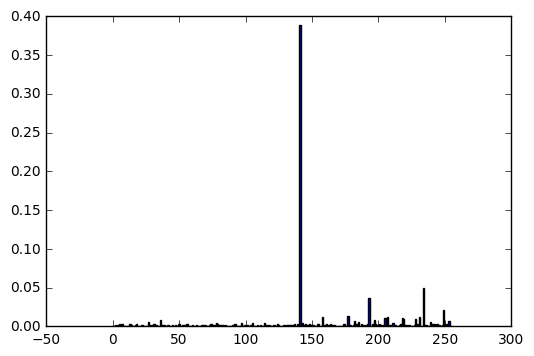

Entropy of distribution: 5.2489213485
Bins:
CudaNdarray([[-0.073568 -0.041863 -0.007353 ..., -0.091026 -0.058232 -0.011349]
 [0.027364 0.167123 0.256773 ..., 0.521499 0.528265 0.434507]
 [-0.185539 -0.203744 -0.185493 ..., -0.008698 0.042175 0.061578]
 ..., 
 [0.035002 0.032932 0.032406 ..., 0.003856 -0.006742 -0.013844]
 [0.028271 0.019293 0.024473 ..., 0.047657 0.017782 0.024350]
 [0.043193 -0.039840 0.001706 ..., 0.006386 0.036830 0.050234]])


In [31]:
probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
plt.show()

entropy = 0
for i in hist:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

print "Bins:"
print QUANT_BINS.eval()

In [32]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [33]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [34]:
print np.max(embed[25], axis = -1)

[1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 0.995418 0.488037 0.984848 0.784541 0.999984
 0.441929 0.643700 0.711547 0.678562 0.918151 0.966158 0.646281 0.657919
 0.904519 0.999997 0.883040 0.999999 0.649271 0.999993 0.768146 0.469831
 0.964944 0.579325 0.963011 0.988272 0.998098 0.997275 0.996376 0.768489
 0.994797 0.999128 0.999908 0.870672 0.771344 1.000000 0.973543 0.999828
 0.999966 0.995157 0.967272 0.476070 0.999885 0.994198 0.957865 0.999974
 0.996576 1.000000 0.999817 0.659640 0.999999 0.994964 0.942034 0.932829]


In [35]:
np.argmax(embed[25], axis = -1)

array([141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 226, 249,
       141, 141, 141, 242, 198, 193, 193, 172, 211, 141, 141, 114, 141,
       193, 193, 141, 249, 249, 234, 234, 239, 253, 158, 249, 219, 207,
       253, 177, 177, 177,  85, 183, 195,  79,  73, 207, 250, 177, 249,
       182,  98,   5, 134, 137, 210, 218, 229, 192, 205,  31, 232])

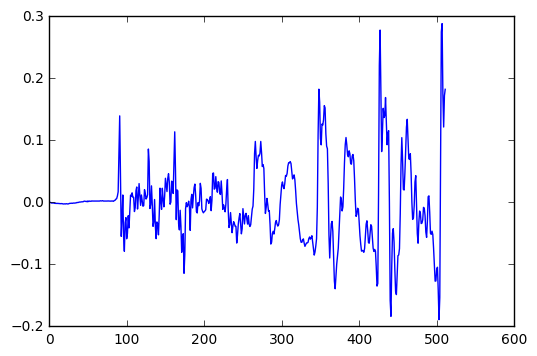

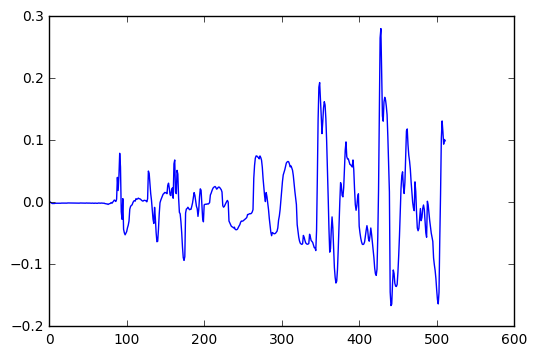

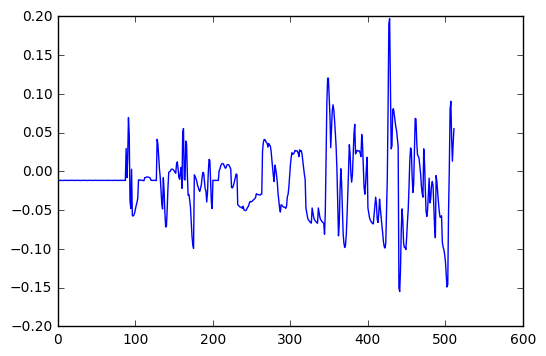

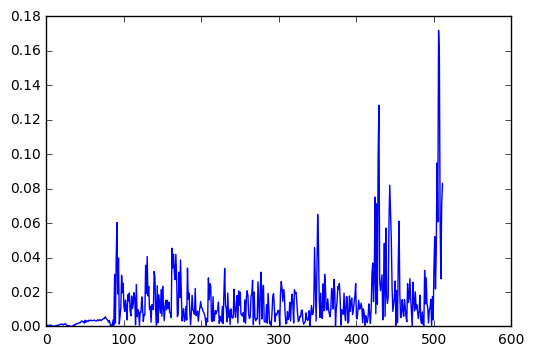

In [36]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

plt.plot(recn)
plt.ylim(ylim)
plt.show()

plt.plot(unquantize_vec(embed[idx]).eval())
plt.show()

plt.plot(abs(orig - recn))
plt.show()